# 1 - Introduction

Name : Gilang Wiradhyaksa

Batch : SBY - 001

Data : [Twitter Sentiment Analysis](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data)

# 2 - Import Libraries

In [49]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tf_hub

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')

import pickle

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GilangW\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GilangW\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 3 - Data Loading

In [11]:
df_ori = pd.read_csv('twitter_training.csv')#, index_col=0)
df_val = pd.read_csv('twitter_validation.csv')#, index_col=0)

In [12]:
df = df_ori.copy()

# 4 - Data Cleaning

In [13]:
df.columns = ['id','entity','sentiment','tweet_content']
df.head()

,id,entity,sentiment,tweet_content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             74681 non-null  int64 
 1   entity         74681 non-null  object
 2   sentiment      74681 non-null  object
 3   tweet_content  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [15]:
df['tweet_content'] = df['tweet_content'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             74681 non-null  int64 
 1   entity         74681 non-null  object
 2   sentiment      74681 non-null  object
 3   tweet_content  74681 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [16]:
df.columns

Index(['id', 'entity', 'sentiment', 'tweet_content'], dtype='object')

In [17]:
# df.rename(columns=lambda x: x.strip().replace(' ', '').lower(), inplace=True)
df = df.rename(columns=lambda x: x.strip())

In [18]:
df.columns

Index(['id', 'entity', 'sentiment', 'tweet_content'], dtype='object')

In [19]:
df.nunique()

id               12447
entity              32
sentiment            4
tweet_content    69491
dtype: int64

In [20]:
print(df['entity'].unique())
print(df['sentiment'].unique())

['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']
['Positive' 'Neutral' 'Negative' 'Irrelevant']


In [21]:
df_val.columns = ['id','entity','sentiment','tweet_content']
df_val.head()

,id,entity,sentiment,tweet_content
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [22]:
print(df_val['entity'].unique())
print(df_val['sentiment'].unique())

['Amazon' 'Microsoft' 'CS-GO' 'Google' 'FIFA' 'MaddenNFL'
 'TomClancysRainbowSix' 'AssassinsCreed' 'CallOfDuty' 'Dota2' 'Verizon'
 'NBA2K' 'Nvidia' 'GrandTheftAuto(GTA)' 'RedDeadRedemption(RDR)'
 'Hearthstone' 'ApexLegends' 'Overwatch'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Borderlands' 'PlayStation5(PS5)'
 'johnson&johnson' 'Fortnite' 'Xbox(Xseries)' 'CallOfDutyBlackopsColdWar'
 'Facebook' 'HomeDepot' 'Cyberpunk2077' 'TomClancysGhostRecon'
 'WorldOfCraft' 'LeagueOfLegends' 'Battlefield']
['Neutral' 'Negative' 'Positive' 'Irrelevant']


# 5 - Feature Engineering

## 5.1 - Text Preprocessing

In [23]:
# INDONESIAN STOPWORDS
# stopwords_nltk = nltk.corpus.stopwords
from nltk.corpus import stopwords
stpwds_id = list(set(stopwords.words('indonesian')))
stpwds_id.append('oh')
print(stpwds_id[:5])

# Define Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer_id = StemmerFactory().create_stemmer()

['bahkan', 'seringnya', 'sangat', 'tahu', 'dijelaskan']


In [24]:
# ENGLISH STOPWORDS
# stopwords_nltk = nltk.corpus.stopwords
stop_words = stopwords.words('english')
print(stop_words[:5])

# Define Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

['i', 'me', 'my', 'myself', 'we']


In [25]:
# Create A Function for Text Preprocessing
def text_preprocessing(text):
  # # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stop_words]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [26]:
# Applying Text Preprocessing to the Dataset

df['text_processed'] = df['tweet_content'].apply(lambda x: text_preprocessing(x))
df

,id,entity,sentiment,tweet_content,text_processed
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im get borderland kill
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im come borderland murder
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im get borderland murder
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im get borderland murder
...,...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...,realiz window partit mac like year behind nvid...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,realiz mac window partit year behind nvidia dr...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,realiz window partit mac year behind nvidia dr...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...,realiz window partit mac like year behind nvid...


## 5.2 Target Conversion

In [27]:
# Display Target
df['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [28]:
# Change Target into Number
df['label'] = df['sentiment'].replace({'Negative' : 0, 'Neutral' : 1, 'Positive' : 2, 'Irrelevant' : 3})
df

,id,entity,sentiment,tweet_content,text_processed,label
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill,2
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im get borderland kill,2
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im come borderland murder,2
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im get borderland murder,2
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im get borderland murder,2
...,...,...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...,realiz window partit mac like year behind nvid...,2
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,realiz mac window partit year behind nvidia dr...,2
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,realiz window partit mac year behind nvidia dr...,2
74679,9200,Nvidia,Positive,Just realized between the windows partition of...,realiz window partit mac like year behind nvid...,2


In [29]:
df[df['sentiment'] == 'Negative'].head()

,id,entity,sentiment,tweet_content,text_processed,label
23,2405,Borderlands,Negative,the biggest dissappoinment in my life came out...,biggest dissappoin life came year ago fuck bor...,0
24,2405,Borderlands,Negative,The biggest disappointment of my life came a y...,biggest disappoint life came year ago,0
25,2405,Borderlands,Negative,The biggest disappointment of my life came a y...,biggest disappoint life came year ago,0
26,2405,Borderlands,Negative,the biggest dissappoinment in my life coming o...,biggest dissappoin life come year ago fuck bor...,0
27,2405,Borderlands,Negative,For the biggest male dissappoinment in my life...,biggest male dissappoin life came hang year ti...,0


In [30]:
df[df['sentiment'] == 'Neutral'].head()

,id,entity,sentiment,tweet_content,text_processed,label
11,2403,Borderlands,Neutral,"Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...",rock hard la varlop rare power handsom jackpot...,1
12,2403,Borderlands,Neutral,"Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...",rock hard la varlop rare power handsom jackpot...,1
13,2403,Borderlands,Neutral,"Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...",rock hard la varlop rare power handsom jackpot...,1
14,2403,Borderlands,Neutral,"Rock-Hard La Vita, RARE BUT POWERFUL, HANDSOME...",rock hard la vita rare power handsom jackpot b...,1
15,2403,Borderlands,Neutral,"Live Rock - Hard music La la Varlope, RARE & t...",live rock hard music la la varlop rare power l...,1


In [31]:
df[df['sentiment'] == 'Irrelevant'].head()

,id,entity,sentiment,tweet_content,text_processed,label
101,2418,Borderlands,Irrelevant,Appreciate the (sonic) concepts / praxis Valen...,appreci sonic concept praxi valenzuela landa p...,3
102,2418,Borderlands,Irrelevant,Appreciate the (sound) concepts / practices th...,appreci sound concept practic valenzuela landa...,3
103,2418,Borderlands,Irrelevant,Evaluate the (sound) concepts / concepts of Va...,evalu sound concept concept valensela landa po...,3
104,2418,Borderlands,Irrelevant,Appreciate the (sonic) concepts / praxis Valen...,appreci sonic concept praxi valenzuela moreno ...,3
105,2418,Borderlands,Irrelevant,Appreciate by the ( sonic ) electronic concept...,appreci sonic electron concept praxi valenzuel...,3


In [32]:
# Target Distribution
df['label'].value_counts()

label
0    22542
2    20831
1    18318
3    12990
Name: count, dtype: int64

In [33]:
df_train = df[['sentiment', 'text_processed', 'label']]
df_train

,sentiment,text_processed,label
0,Positive,come border kill,2
1,Positive,im get borderland kill,2
2,Positive,im come borderland murder,2
3,Positive,im get borderland murder,2
4,Positive,im get borderland murder,2
...,...,...,...
74676,Positive,realiz window partit mac like year behind nvid...,2
74677,Positive,realiz mac window partit year behind nvidia dr...,2
74678,Positive,realiz window partit mac year behind nvidia dr...,2
74679,Positive,realiz window partit mac like year behind nvid...,2


## 5.3 Split Feature(X), Target(y) and Train Set, Test Set

In [34]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df_train.text_processed,
                                                    df_train.label,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    stratify=df_train.label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (57130,)
Val Size   :  (6348,)
Test Size  :  (11203,)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

In [35]:
X_train.head()

56120    honestli need find stronger team pc bad hit al...
14769                                       noob indog way
31079    error transfer code mordekais dark star skin c...
8773                                      well overtim lit
63377                            talk got ta fix slow menu
Name: text_processed, dtype: object

In [36]:
y_train.head()

56120    1
14769    3
31079    0
8773     2
63377    0
Name: label, dtype: int64

## 5.4 Feature Encoding

In [37]:
# Change Target to One Hot Encoding

from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

# 6 - Model Building

## 6.1 Text Vectorization

In [38]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<57130x21139 sparse matrix of type '<class 'numpy.int64'>'
	with 574899 stored elements in Compressed Sparse Row format>

In [39]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  21139
Maximum Sentence Length :  163 tokens


In [40]:
# Text Vectorization

from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [41]:
# Example Result

## Document example
print('Document example')
print(df_train.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df_train.text_processed[0]]))
print('Vector size : ', text_vectorization([df_train.text_processed[0]]).shape)

Document example
come border kill

Result of Text Vectorization
tf.Tensor(
[[  61 1617  121    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]], shape=(1, 163), dtype=int64)
Vector size :  (1, 163)


In [42]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'game',
 'com',
 's',
 'play',
 'nt',
 'get',
 'like',
 'pic',
 'fuck',
 'twitter',
 'go',
 'love',
 'one',
 'good',
 'time',
 'new',
 'realli',
 'see']

## 6.2 Word Embedding

In [43]:
# Embedding

from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [44]:
# Example Result

## Document example
print('Document example')
print(df_train.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df_train.text_processed[0]]))
print('Vector size : ', text_vectorization([df_train.text_processed[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df_train.text_processed[0]])))
print('Vector size : ', embedding(text_vectorization([df_train.text_processed[0]])).shape)

Document example
come border kill

Result of  Text Vectorization
tf.Tensor(
[[  61 1617  121    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]], shape=(1, 163), dtype=int64)
Vector size :  (1, 163)

Result of  Embedding
tf.Tens

## 6.3 Model Training

In [45]:
# Model Training using LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape

### 6.3.1 LSTM - Default Batch

In [46]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(32, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(4, activation='softmax'))

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=20, validation_data=(X_val, y_val_ohe))

Epoch 1/20
1786/1786 [==============================] - 297s 163ms/step - loss: 0.8440 - accuracy: 0.6642 - val_loss: 0.5832 - val_accuracy: 0.7851
Epoch 2/20
1786/1786 [==============================] - 268s 150ms/step - loss: 0.4175 - accuracy: 0.8458 - val_loss: 0.4426 - val_accuracy: 0.8362
Epoch 3/20
1786/1786 [==============================] - 273s 153ms/step - loss: 0.2953 - accuracy: 0.8870 - val_loss: 0.4405 - val_accuracy: 0.8440
Epoch 4/20
1786/1786 [==============================] - 287s 161ms/step - loss: 0.2385 - accuracy: 0.9059 - val_loss: 0.4303 - val_accuracy: 0.8475
Epoch 5/20
1786/1786 [==============================] - 275s 154ms/step - loss: 0.2070 - accuracy: 0.9168 - val_loss: 0.4407 - val_accuracy: 0.8533
Epoch 6/20
1786/1786 [==============================] - 265s 148ms/step - loss: 0.1787 - accuracy: 0.9271 - val_loss: 0.4512 - val_accuracy: 0.8607
Epoch 7/20
1786/1786 [==============================] - 263s 147ms/step - loss: 0.1596 - accuracy: 0.9341 - val_

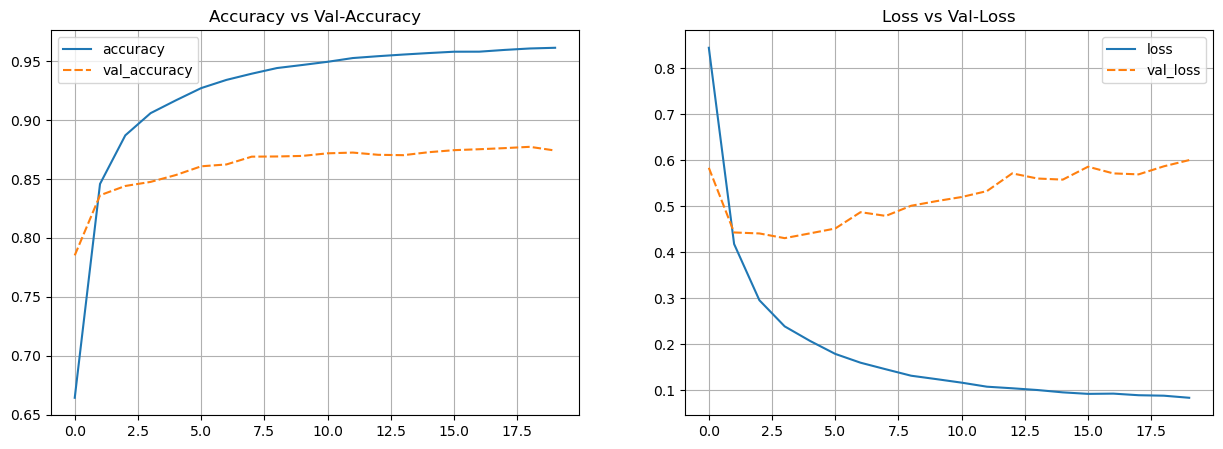

In [50]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

### 6.3.2 LSTM - 128 batch

In [83]:
## Batch Size 128

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_3 = Sequential()
model_lstm_3.add(text_vectorization)
model_lstm_3.add(embedding)
model_lstm_3.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_3.add(Dropout(0.1))
model_lstm_3.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_3.add(Dropout(0.1))
model_lstm_3.add(Dense(4, activation='softmax'))

model_lstm_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

batch = 128
model_lstm_3_hist = model_lstm_3.fit(X_train, y_train_ohe, epochs=20, batch_size=batch, validation_data=(X_val, y_val_ohe))

Epoch 1/20
447/447 [==============================] - 60s 124ms/step - loss: 0.4402 - accuracy: 0.8409 - val_loss: 0.4440 - val_accuracy: 0.8450
Epoch 2/20
447/447 [==============================] - 50s 113ms/step - loss: 0.1667 - accuracy: 0.9345 - val_loss: 0.4398 - val_accuracy: 0.8592
Epoch 3/20
447/447 [==============================] - 50s 112ms/step - loss: 0.1226 - accuracy: 0.9492 - val_loss: 0.4832 - val_accuracy: 0.8685
Epoch 4/20
447/447 [==============================] - 51s 115ms/step - loss: 0.1086 - accuracy: 0.9539 - val_loss: 0.5302 - val_accuracy: 0.8656
Epoch 5/20
447/447 [==============================] - 50s 113ms/step - loss: 0.1004 - accuracy: 0.9553 - val_loss: 0.5816 - val_accuracy: 0.8612
Epoch 6/20
447/447 [==============================] - 52s 116ms/step - loss: 0.0974 - accuracy: 0.9566 - val_loss: 0.5712 - val_accuracy: 0.8664
Epoch 7/20
447/447 [==============================] - 51s 113ms/step - loss: 0.0919 - accuracy: 0.9586 - val_loss: 0.6195 - val_ac

c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

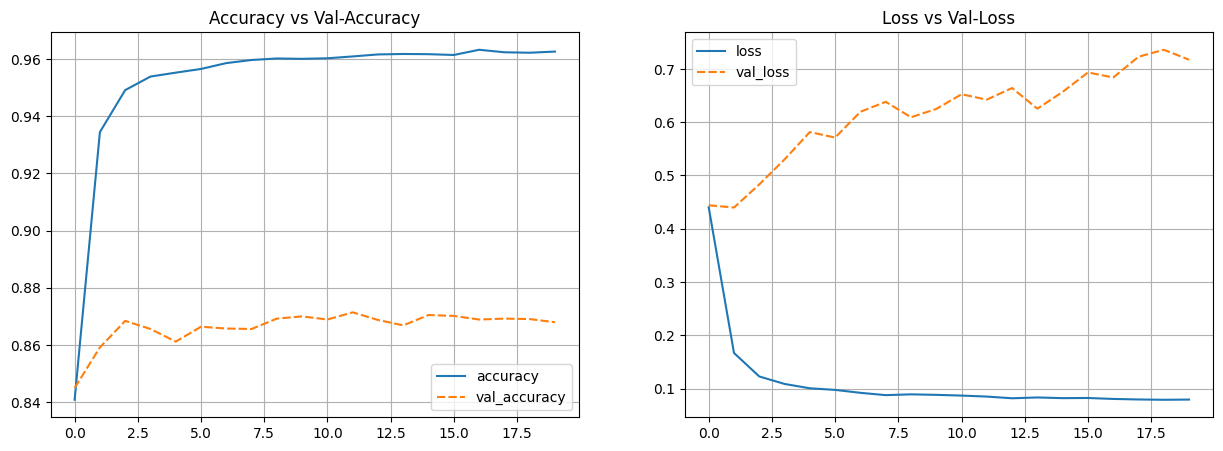

In [85]:
# Plot Training Results

model_lstm_3_hist_df = pd.DataFrame(model_lstm_3_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_3_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_3_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

### test lstm

In [46]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_5 = Sequential()
model_lstm_5.add(text_vectorization)
model_lstm_5.add(embedding)
model_lstm_5.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_5.add(Dropout(0.1))
model_lstm_5.add(Bidirectional(LSTM(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_5.add(Dropout(0.1))
model_lstm_5.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_5.add(Dropout(0.1))
model_lstm_5.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_5.add(Dropout(0.1))
model_lstm_5.add(Dense(4, activation='softmax'))

model_lstm_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

batch = 32
model_lstm_5_hist = model_lstm_5.fit(X_train, y_train_ohe, epochs=20, batch_size=batch, validation_data=(X_val, y_val_ohe))

Epoch 1/20
1786/1786 [==============================] - 422s 226ms/step - loss: 0.3118 - accuracy: 0.8845 - val_loss: 0.4454 - val_accuracy: 0.8522
Epoch 2/20
1786/1786 [==============================] - 403s 226ms/step - loss: 0.1607 - accuracy: 0.9361 - val_loss: 0.4483 - val_accuracy: 0.8704
Epoch 3/20
1786/1786 [==============================] - 401s 225ms/step - loss: 0.1341 - accuracy: 0.9440 - val_loss: 0.4701 - val_accuracy: 0.8735
Epoch 4/20
1786/1786 [==============================] - 397s 222ms/step - loss: 0.1217 - accuracy: 0.9484 - val_loss: 0.5496 - val_accuracy: 0.8546
Epoch 5/20
1786/1786 [==============================] - 380s 213ms/step - loss: 0.1113 - accuracy: 0.9519 - val_loss: 0.5351 - val_accuracy: 0.8737
Epoch 6/20
1786/1786 [==============================] - 383s 214ms/step - loss: 0.1074 - accuracy: 0.9533 - val_loss: 0.5252 - val_accuracy: 0.8762
Epoch 7/20
1786/1786 [==============================] - 386s 216ms/step - loss: 0.1023 - accuracy: 0.9551 - val_

### 6.3.3 LSTM with Transfer Learning - Default Batch

In [41]:
# Download the Embedding Layer

url = 'https://tfhub.dev/google/tf2-preview/nnlm-id-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [77]:
## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((128, 1)))
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Dense(4, activation='softmax'))

model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_2_hist = model_lstm_2.fit(X_train, y_train_ohe, epochs=20, validation_data=(X_val, y_val_ohe))

Epoch 1/20
1786/1786 [==============================] - 60s 31ms/step - loss: 1.3557 - accuracy: 0.3246 - val_loss: 1.3452 - val_accuracy: 0.3458
Epoch 2/20
1786/1786 [==============================] - 55s 31ms/step - loss: 1.3384 - accuracy: 0.3580 - val_loss: 1.3333 - val_accuracy: 0.3589
Epoch 3/20
1786/1786 [==============================] - 57s 32ms/step - loss: 1.3323 - accuracy: 0.3636 - val_loss: 1.3271 - val_accuracy: 0.3678
Epoch 4/20
1786/1786 [==============================] - 64s 36ms/step - loss: 1.3263 - accuracy: 0.3711 - val_loss: 1.3411 - val_accuracy: 0.3499
Epoch 5/20
1786/1786 [==============================] - 63s 35ms/step - loss: 1.3261 - accuracy: 0.3697 - val_loss: 1.3313 - val_accuracy: 0.3683
Epoch 6/20
1786/1786 [==============================] - 62s 35ms/step - loss: 1.3178 - accuracy: 0.3790 - val_loss: 1.3221 - val_accuracy: 0.3708
Epoch 7/20
1786/1786 [==============================] - 76s 42ms/step - loss: 1.3134 - accuracy: 0.3821 - val_loss: 1.3165 -

c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

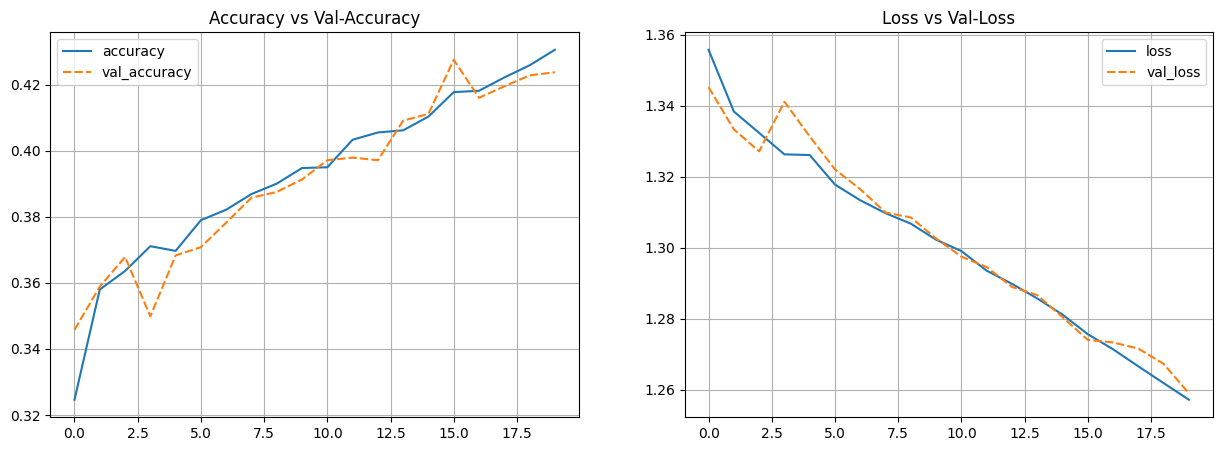

In [78]:
# Plot Training Results

model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

### 6.3.4 LSTM with Transfer Learning - 128 Batch

In [86]:
# Model Training using LSTM with Transfer Learning - 128 Batch

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_4 = Sequential()
model_lstm_4.add(hub_layer)
model_lstm_4.add(Reshape((128, 1)))
model_lstm_4.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_4.add(Dropout(0.1))
model_lstm_4.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_4.add(Dropout(0.1))
model_lstm_4.add(Dense(4, activation='softmax'))

model_lstm_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

batch = 128
model_lstm_4_hist = model_lstm_4.fit(X_train, y_train_ohe, epochs=20, batch_size=batch, validation_data=(X_val, y_val_ohe))

Epoch 1/20
447/447 [==============================] - 42s 77ms/step - loss: 1.3610 - accuracy: 0.3170 - val_loss: 1.3517 - val_accuracy: 0.3349
Epoch 2/20
447/447 [==============================] - 34s 75ms/step - loss: 1.3440 - accuracy: 0.3520 - val_loss: 1.3348 - val_accuracy: 0.3680
Epoch 3/20
447/447 [==============================] - 36s 81ms/step - loss: 1.3335 - accuracy: 0.3656 - val_loss: 1.3289 - val_accuracy: 0.3743
Epoch 4/20
447/447 [==============================] - 35s 78ms/step - loss: 1.3286 - accuracy: 0.3714 - val_loss: 1.3307 - val_accuracy: 0.3696
Epoch 5/20
447/447 [==============================] - 33s 75ms/step - loss: 1.3245 - accuracy: 0.3752 - val_loss: 1.3328 - val_accuracy: 0.3647
Epoch 6/20
447/447 [==============================] - 32s 72ms/step - loss: 1.3218 - accuracy: 0.3766 - val_loss: 1.3205 - val_accuracy: 0.3718
Epoch 7/20
447/447 [==============================] - 33s 74ms/step - loss: 1.3179 - accuracy: 0.3797 - val_loss: 1.3234 - val_accuracy:

c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

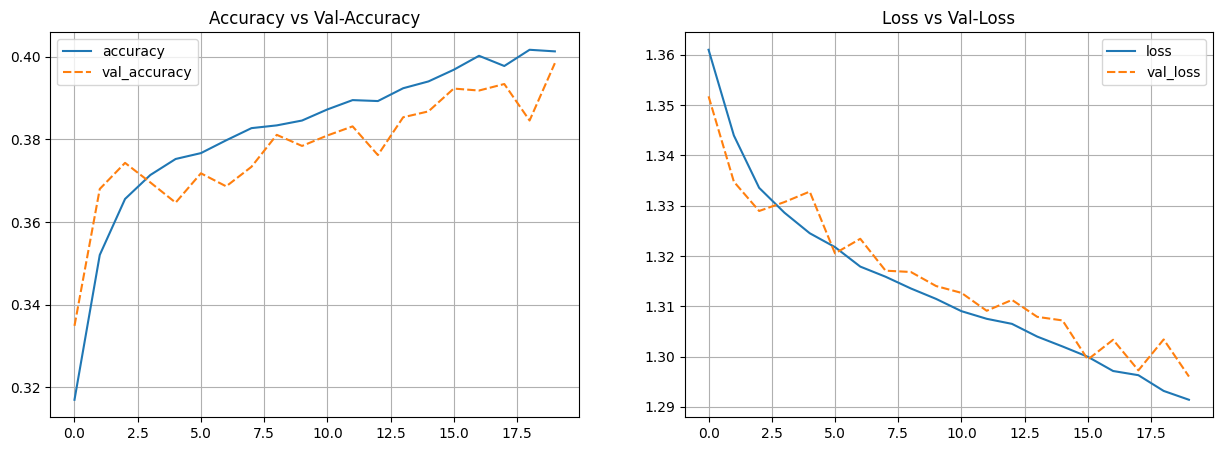

In [87]:
# Plot Training Results

model_lstm_4_hist_df = pd.DataFrame(model_lstm_4_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_4_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_4_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

# 7 - Model Saving

In [51]:
#MODEL
with open('model_lstm_1.pkl', 'wb') as file_1:
    pickle.dump(model_lstm_1, file_1)

#TEXT PREPROCESSING
with open('text_preprocessing.pkl', 'wb') as file_2:
    pickle.dump(text_preprocessing, file_2)